<a href="https://colab.research.google.com/github/alaa-shehab/Head-Pose-Estimation/blob/main/ML1_Head_Pose_Estimation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Required Libraries

In [3]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

### Dowlining Data

In [ ]:
!unzip /content/drive/MyDrive/ML1/AFLW2000-3D.zip

In [6]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Preparing Data

In [7]:
import glob

img_dir = '/content/AFLW2000/*.jpg'
mat_dir = '/content/AFLW2000/*.mat'

image_files = glob.glob(img_dir)
mat_files = glob.glob(mat_dir)


In [15]:
# choosing random image
features = []
poses = []
nose = []
chin = []
x_features = []
y_features = []
faceModule = mediapipe.solutions.face_mesh

# loading image and its corresponding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    for image, mat_file in zip(sorted(image_files), sorted(mat_files)):
        image_x = []
        image_y = []
        img = cv2.imread(image)
        results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        if results.multi_face_landmarks:
            if os.path.splitext(image)[0] == os.path.splitext(mat_file)[0]:
                mat = sio.loadmat(mat_file)
                poses.append(mat['Pose_Para'][0][:3])

            for face in results.multi_face_landmarks:

                for idx, landmark in enumerate(face.landmark):

                    x = landmark.x
                    y = landmark.y

                    image_x.append(x)
                    image_y.append(y)


                    if idx == 1:
                        nose.append([x, y])
                    elif idx == 152:
                        chin.append([x, y])



                x_features.append(image_x)
                y_features.append(image_y)


In [16]:
nose = np.array(nose)
chin = np.array(chin)

In [17]:
centered_x = np.array(x_features) - nose[:,0].reshape(-1,1)
centered_y = np.array(y_features) - nose[:,1].reshape(-1,1)

In [18]:
distance = np.sqrt((nose[:, 0] - chin[:, 0]) ** 2 + (nose[:, 1] - chin[:, 1]) ** 2)
distance[distance == 0] = 1

In [19]:
normalized_x = centered_x/distance.reshape(-1,1)
normalized_y = centered_y/distance.reshape(-1,1)

In [20]:
normalized_x = np.array(normalized_x)
normalized_y = np.array(normalized_y)

features = np.hstack([normalized_x, normalized_y])

## Splitting Data

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(features, poses, train_size=0.80, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.10, random_state=42)

In [22]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [23]:
pitch_train = y_train[:,0]
yaw_train = y_train[:,1]
roll_train = y_train[:,2]

In [24]:
pitch_val = y_val[:,0]
yaw_val = y_val[:,1]
roll_val = y_val[:,2]

In [25]:
pitch_test = y_test[:,0]
yaw_test = y_test[:,1]
roll_test = y_test[:,2]

## Model Training

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
import matplotlib.pyplot as plt

### Linear Regression

In [26]:
lr_pitch =LinearRegression(fit_intercept=True, copy_X=True)

lr_pitch.fit(X_train, pitch_train)

LinearRegression()

In [27]:
print(f"Train Accuracy: {lr_pitch.score(X_train, pitch_train)}")
print(f"Validation Accuracy: {lr_pitch.score(X_val, pitch_val)}")

Train Accuracy: 0.9715447069095399
Validation Accuracy: -2.319877131617806


In [28]:
pitch_pred = lr_pitch.predict(X_val)
mse = mean_squared_error(pitch_val, pitch_pred)
mae = mean_absolute_error(pitch_val, pitch_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.24405906729113017
MAE: 0.304076176044855


In [29]:
lr_yaw = LinearRegression(fit_intercept=True, copy_X=True)
lr_yaw.fit(X_train, yaw_train)

LinearRegression()

In [30]:
print(f"Train Accuracy: {lr_yaw.score(X_train, yaw_train)}")
print(f"Validation Accuracy: {lr_yaw.score(X_val, yaw_val)}")

Train Accuracy: 0.9839081565368475
Validation Accuracy: 0.7628907254498896


In [31]:
yaw_pred = lr_yaw.predict(X_val)
mse = mean_squared_error(yaw_val, yaw_pred)
mae = mean_absolute_error(yaw_val, yaw_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.0598108818951092
MAE: 0.17488947299487034


In [32]:
lr_roll =LinearRegression(fit_intercept=True, copy_X=True)

lr_roll.fit(X_train, roll_train)

LinearRegression()

In [33]:
print(f"Train Accuracy: {lr_roll.score(X_train, roll_train)}")
print(f"Validation Accuracy: {lr_roll.score(X_val, roll_val)}")

Train Accuracy: 0.9789682814356676
Validation Accuracy: -0.9804363725691261


In [34]:
roll_pred = lr_roll.predict(X_val)
mse = mean_squared_error(roll_val, roll_pred)
mae = mean_absolute_error(roll_val, roll_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.19244121144223877
MAE: 0.25573267745973216


In [36]:
pitch_pred = lr_pitch.predict(X_test)
yaw_pred = lr_yaw.predict(X_test)
roll_pred = lr_roll.predict(X_test)

print("MAE Pitch: ", mean_absolute_error(pitch_test, pitch_pred))
print("MSE Pitch: ", mean_squared_error(pitch_test, pitch_pred))
print("MAE Yaw: ", mean_absolute_error(yaw_test, yaw_pred))
print("MSE Yaw: ", mean_squared_error(yaw_test, yaw_pred))
print("MAE Roll: ", mean_absolute_error(roll_test, roll_pred))
print("MSE Roll: ", mean_squared_error(roll_test, roll_pred))

MAE Pitch:  0.3632341371418809
MSE Pitch:  0.2786056574813549
MAE Yaw:  0.2539396029763125
MSE Yaw:  0.118901972286183
MAE Roll:  0.25041532384205134
MSE Roll:  0.15616959194476462


### Ridge

In [37]:
ridge_pitch = Ridge(alpha=.1)
ridge_pitch.fit(X_train, pitch_train)

Ridge(alpha=0.1)

In [38]:
print(f"Train Accuracy: {ridge_pitch.score(X_train, pitch_train)}")
print(f"Validation Accuracy: {ridge_pitch.score(X_val, pitch_val)}")

Train Accuracy: 0.2961027816238454
Validation Accuracy: 0.09866561646981675


In [39]:
pitch_pred = ridge_pitch.predict(X_val)
mse = mean_squared_error(pitch_val, pitch_pred)
mae = mean_absolute_error(pitch_val, pitch_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.06626113565070545
MAE: 0.15080905490494942


In [40]:
ridge_yaw = Ridge(alpha=.1)
ridge_yaw.fit(X_train, yaw_train)

Ridge(alpha=0.1)

In [41]:
print(f"Train Accuracy: {ridge_yaw.score(X_train, yaw_train)}")
print(f"Validation Accuracy: {ridge_yaw.score(X_val, yaw_val)}")

Train Accuracy: 0.8745191882930431
Validation Accuracy: 0.9475010947005809


In [42]:
yaw_pred = ridge_yaw.predict(X_val)
mse = mean_squared_error(yaw_val, yaw_pred)
mae = mean_absolute_error(yaw_val, yaw_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.013242863782717508
MAE: 0.07696880710628878


In [43]:
ridge_roll = Ridge(alpha=.1)
ridge_roll.fit(X_train, roll_train)

Ridge(alpha=0.1)

In [44]:
print(f"Train Accuracy: {ridge_roll.score(X_train, roll_train)}")
print(f"Validation Accuracy: {ridge_roll.score(X_val, roll_val)}")

Train Accuracy: 0.587034508532307
Validation Accuracy: 0.06056072420710623


In [45]:
roll_pred = ridge_roll.predict(X_val)
mse = mean_squared_error(roll_val, roll_pred)
mae = mean_absolute_error(roll_val, roll_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.09128636234623269
MAE: 0.19345472219361684


In [46]:
pitch_pred = ridge_pitch.predict(X_test)
yaw_pred = ridge_yaw.predict(X_test)
roll_pred = ridge_roll.predict(X_test)

print("MAE Pitch: ", mean_absolute_error(pitch_test, pitch_pred))
print("MSE Pitch: ", mean_squared_error(pitch_test, pitch_pred))
print("MAE Yaw: ", mean_absolute_error(yaw_test, yaw_pred))
print("MSE Yaw: ", mean_squared_error(yaw_test, yaw_pred))
print("MAE Roll: ", mean_absolute_error(roll_test, roll_pred))
print("MSE Roll: ", mean_squared_error(roll_test, roll_pred))

MAE Pitch:  0.1560401018198298
MSE Pitch:  0.05430435656838488
MAE Yaw:  0.08849631414967443
MSE Yaw:  0.014959691214389517
MAE Roll:  0.250713614632206
MSE Roll:  0.19185040513028734


### Lasso

In [47]:
pitch_lasso = Lasso(alpha=.01)
pitch_lasso.fit(X_train, pitch_train)

Lasso(alpha=0.01)

In [48]:
print(f"Train Accuracy: {pitch_lasso.score(X_train, pitch_train)}")
print(f"Validation Accuracy: {pitch_lasso.score(X_val, pitch_val)}")

Train Accuracy: 0.13698743007775738
Validation Accuracy: 0.6548090691332081


In [49]:
pitch_pred = pitch_lasso.predict(X_val)
mse = mean_squared_error(pitch_val, pitch_pred)
mae = mean_absolute_error(pitch_val, pitch_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.025376534517604847
MAE: 0.10075427598494002


In [50]:
yaw_lasso = Lasso(alpha=.01)
yaw_lasso.fit(X_train, yaw_train)

Lasso(alpha=0.01)

In [51]:
print(f"Train Accuracy: {yaw_lasso.score(X_train, yaw_train)}")
print(f"Validation Accuracy: {yaw_lasso.score(X_val, yaw_val)}")

Train Accuracy: 0.8194394933414497
Validation Accuracy: 0.9270907967354252


In [52]:
yaw_pred = yaw_lasso.predict(X_val)
mse = mean_squared_error(yaw_val, yaw_pred)
mae = mean_absolute_error(yaw_val, yaw_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.018391367245326366
MAE: 0.10114099652351696


In [53]:
roll_lasso = Lasso(alpha=.01)
roll_lasso.fit(X_train, roll_train)

Lasso(alpha=0.01)

In [54]:
print(f"Train Accuracy: {roll_lasso.score(X_train, roll_train)}")
print(f"Validation Accuracy: {roll_lasso.score(X_val, roll_val)}")

Train Accuracy: 0.28731885954160885
Validation Accuracy: 0.65739479145279


In [55]:
roll_pred = roll_lasso.predict(X_val)
mse = mean_squared_error(roll_val, roll_pred)
mae = mean_absolute_error(roll_val, roll_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.03329133028076854
MAE: 0.10691496037686748


In [56]:
pitch_pred = pitch_lasso.predict(X_test)
yaw_pred = yaw_lasso.predict(X_test)
roll_pred = roll_lasso.predict(X_test)

print("MAE Pitch: ", mean_absolute_error(pitch_test, pitch_pred))
print("MSE Pitch: ", mean_squared_error(pitch_test, pitch_pred))
print("MAE Yaw: ", mean_absolute_error(yaw_test, yaw_pred))
print("MSE Yaw: ", mean_squared_error(yaw_test, yaw_pred))
print("MAE Roll: ", mean_absolute_error(roll_test, roll_pred))
print("MSE Roll: ", mean_squared_error(roll_test, roll_pred))

MAE Pitch:  0.10380184273464309
MSE Pitch:  0.021613835935461744
MAE Yaw:  0.11904557345823347
MSE Yaw:  0.02715428068198037
MAE Roll:  0.1172482808278134
MSE Roll:  0.02899961432548022


### SVM

In [57]:
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [63]:
svm_model = SVR()

param = {
    'kernel': ['rbf'],
    'C': [0.01, 0.1, 1, 10, 20],
    'gamma': [0.01, 0.1, 1, 10, 20]
}

pitch_search = GridSearchCV(estimator=svm_model, param_grid=param)
pitch_search.fit(X_train, pitch_train)

best_params = pitch_search.best_params_

best_svm_model = pitch_search.best_estimator_

pitch_pred = best_svm_model.predict(X_val)
mse = mean_squared_error(pitch_val, pitch_pred)
mae = mean_absolute_error(pitch_val, pitch_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.026478187247494695
MAE: 0.08658396681725145


In [65]:
print("Train acc: ", best_svm_model.score(X_train, pitch_train))
print("Validation acc: ", best_svm_model.score(X_val, pitch_val))

Train acc:  0.28376504883813136
Validation acc:  0.6398235504817626


In [66]:
yaw_search =  GridSearchCV(estimator=svm_model, param_grid=param)
yaw_search.fit(X_train, yaw_train)

yaw_svm_model = yaw_search.best_estimator_

yaw_pred = yaw_svm_model.predict(X_val)
mse = mean_squared_error(yaw_val, yaw_pred)
mae = mean_absolute_error(yaw_val, yaw_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")


MSE: 0.013536860266405758
MAE: 0.061364434709814085


In [67]:
print("Train acc: ", yaw_svm_model.score(X_train, yaw_train))
print("Validation acc: ", yaw_svm_model.score(X_val, yaw_val))

Train acc:  0.8650313197117327
Validation acc:  0.9463355995472097


In [68]:
roll_search = GridSearchCV(estimator=svm_model, param_grid=param)
roll_search.fit(X_train, roll_train)


roll_svm_model = roll_search.best_estimator_


roll_pred = roll_svm_model.predict(X_val)
mse = mean_squared_error(roll_val, roll_pred)
mae = mean_absolute_error(roll_val, roll_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.014030241565320687
MAE: 0.05845621563438022


In [69]:
print("Train acc: ", roll_svm_model.score(X_train, roll_train))
print("Validation acc: ", roll_svm_model.score(X_val, roll_val))

Train acc:  0.3078439075226159
Validation acc:  0.8556130440894036


In [70]:
pitch_pred = best_svm_model.predict(X_test)
yaw_pred = yaw_svm_model.predict(X_test)
roll_pred = roll_svm_model.predict(X_test)

print("MAE Pitch: ", mean_absolute_error(pitch_test, pitch_pred))
print("MSE Pitch: ", mean_squared_error(pitch_test, pitch_pred))
print("MAE Yaw: ", mean_absolute_error(yaw_test, yaw_pred))
print("MSE Yaw: ", mean_squared_error(yaw_test, yaw_pred))
print("MAE Roll: ", mean_absolute_error(roll_test, roll_pred))
print("MSE Roll: ", mean_squared_error(roll_test, roll_pred))

MAE Pitch:  0.09724425186617029
MSE Pitch:  0.04188616891688921
MAE Yaw:  0.08179685419682442
MSE Yaw:  0.015806327257261304
MAE Roll:  0.04495132511650009
MSE Roll:  0.006276327466533613


### Random Forest Regressor

In [71]:
from sklearn.ensemble import RandomForestRegressor
pitch_rf = RandomForestRegressor(n_estimators=25, max_depth=25,random_state=42)
pitch_rf.fit(X_train, pitch_train)

print("Train acc: ", pitch_rf.score(X_train, pitch_train))
print("Validation acc: ", pitch_rf.score(X_val, pitch_val))

pitch_pred = pitch_rf.predict(X_val)



Train acc:  0.8138358716736771
Validation acc:  0.4584812705590774


In [72]:
mse = mean_squared_error(pitch_val, pitch_pred)
mae = mean_absolute_error(pitch_val, pitch_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.039809472094416175
MAE: 0.09880425761107814


In [73]:
yaw_rf = RandomForestRegressor(n_estimators=25, max_depth=25,random_state=42)
yaw_rf.fit(X_train, yaw_train)

print("Train acc: ", yaw_rf.score(X_train, yaw_train))
print("Validation acc: ", yaw_rf.score(X_val, yaw_val))

Train acc:  0.9770315194389537
Validation acc:  0.8312526972230474


In [74]:
yaw_pred = yaw_rf.predict(X_val)
mse = mean_squared_error(yaw_val, yaw_pred)
mae = mean_absolute_error(yaw_val, yaw_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.04256655508588095
MAE: 0.08486158885058122


In [75]:
roll_rf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=100, min_samples_split=50, min_samples_leaf=50)
roll_rf.fit(X_train, roll_train)

print("Train acc: ", roll_rf.score(X_train, roll_train))
print("Validation acc: ", roll_rf.score(X_val, roll_val))


Train acc:  0.2588885209878904
Validation acc:  0.7201677876778716


In [76]:
roll_pred = roll_rf.predict(X_val)
mse = mean_squared_error(roll_val, roll_pred)
mae = mean_absolute_error(roll_val, roll_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.027191608216109213
MAE: 0.08290163918927147


In [78]:
pitch_pred = pitch_rf.predict(X_test)
yaw_pred = yaw_rf.predict(X_test)
roll_pred = roll_rf.predict(X_test)

print("MAE Pitch: ", mean_absolute_error(pitch_test, pitch_pred))
print("MSE Pitch: ", mean_squared_error(pitch_test, pitch_pred))
print("MAE Yaw: ", mean_absolute_error(yaw_test, yaw_pred))
print("MSE Yaw: ", mean_squared_error(yaw_test, yaw_pred))
print("MAE Roll: ", mean_absolute_error(roll_test, roll_pred))
print("MSE Roll: ", mean_squared_error(roll_test, roll_pred))

MAE Pitch:  0.16495713907404266
MSE Pitch:  0.1774512005246989
MAE Yaw:  0.09917250325866532
MSE Yaw:  0.021900188716398403
MAE Roll:  0.07076404993718335
MSE Roll:  0.01853107853694962


### XGB

In [79]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint, uniform

In [84]:
xgb_pitch = XGBRegressor(learning_rate=0.001, n_estimators=25, max_depth=10)
xgb_pitch.fit(X_train, pitch_train)

print("Train acc: ", xgb_pitch.score(X_train, pitch_train))
print("Validation acc: ", xgb_pitch.score(X_val, pitch_val))

Train acc:  0.027904767436595757
Validation acc:  0.03339171444897282


In [85]:
pitch_pred = xgb_pitch.predict(X_val)
mse = mean_squared_error(pitch_val, pitch_pred)
mae = mean_absolute_error(pitch_val, pitch_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.0710597112774849
MAE: 0.19370262324810028


In [86]:
xgb_yaw = XGBRegressor(learning_rate=0.001, n_estimators=25, max_depth=10, gamma=0.1)
xgb_yaw.fit(X_train, yaw_train)

print("Train acc: ", xgb_yaw.score(X_train, yaw_train))
print("Validation acc: ", xgb_yaw.score(X_val, yaw_val))

Train acc:  0.04407453443745857
Validation acc:  0.04610205672907597


In [87]:
yaw_pred = xgb_yaw.predict(X_val)
mse = mean_squared_error(yaw_val, yaw_pred)
mae = mean_absolute_error(yaw_val, yaw_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.24062101542949677
MAE: 0.3635120689868927


In [88]:
xgb_roll = XGBRegressor(learning_rate=0.001, n_estimators=25, max_depth=10, gamma=0.1)
xgb_roll.fit(X_train, yaw_train)

print("Train acc: ", xgb_roll.score(X_train, roll_train))
print("Validation acc: ", xgb_roll.score(X_val, roll_val))

Train acc:  -0.0053831992488058145
Validation acc:  -0.03790162415746745


In [89]:
roll_pred = xgb_yaw.predict(X_val)
mse = mean_squared_error(roll_val, roll_pred)
mae = mean_absolute_error(roll_val, roll_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.1008540689945221
MAE: 0.22592589259147644


In [91]:
pitch_pred = xgb_pitch.predict(X_test)
yaw_pred = xgb_yaw.predict(X_test)
roll_pred = xgb_roll.predict(X_test)

print("MAE Pitch: ", mean_absolute_error(pitch_test, pitch_pred))
print("MSE Pitch: ", mean_squared_error(pitch_test, pitch_pred))
print("MAE Yaw: ", mean_absolute_error(yaw_test, yaw_pred))
print("MSE Yaw: ", mean_squared_error(yaw_test, yaw_pred))
print("MAE Roll: ", mean_absolute_error(roll_test, roll_pred))
print("MSE Roll: ", mean_squared_error(roll_test, roll_pred))

MAE Pitch:  0.1854977
MSE Pitch:  0.06422503
MAE Yaw:  0.37294447
MSE Yaw:  0.24849291
MAE Roll:  0.22692911
MSE Roll:  0.14383192


### Gradient Boosting

In [92]:
from sklearn.ensemble import GradientBoostingRegressor

In [93]:
gb_pitch = GradientBoostingRegressor(n_estimators=30, learning_rate=0.01, max_depth=15)
gb_pitch.fit(X_train, pitch_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=15, n_estimators=30)

In [94]:
print("Train acc: ", gb_pitch.score(X_train, pitch_train))
print("Validation acc: ", gb_pitch.score(X_val, pitch_val))

Train acc:  0.45180218836131547
Validation acc:  0.05442037777656272


In [95]:
pitch_pred = gb_pitch.predict(X_val)
mse = mean_squared_error(pitch_val, pitch_pred)
mae = mean_absolute_error(pitch_val, pitch_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.06951380171617721
MAE: 0.16315103845290627


In [96]:
gb_yaw = GradientBoostingRegressor(n_estimators=50, learning_rate=0.01, max_depth=10)
gb_yaw.fit(X_train, yaw_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=50)

In [97]:
print("Train acc: ", gb_yaw.score(X_train, yaw_train))
print("Validation acc: ", gb_yaw.score(X_val, yaw_val))

Train acc:  0.6318350767667325
Validation acc:  0.5730782067832023


In [98]:
yaw_pred = gb_yaw.predict(X_val)
mse = mean_squared_error(yaw_val, yaw_pred)
mae = mean_absolute_error(yaw_val, yaw_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.1076911436762111
MAE: 0.23564023532078987


In [99]:
gb_roll = GradientBoostingRegressor(n_estimators=30, learning_rate=0.01, max_depth=15)
gb_roll.fit(X_train, roll_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=15, n_estimators=30)

In [100]:
print("Train acc: ", gb_roll.score(X_train, roll_train))
print("Validation acc: ", gb_roll.score(X_val, roll_val))

Train acc:  0.4526386652416132
Validation acc:  0.07432951939019361


In [101]:
roll_pred = gb_roll.predict(X_val)
mse = mean_squared_error(roll_val, roll_pred)
mae = mean_absolute_error(roll_val, roll_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.08994843315959788
MAE: 0.17556758224648136


In [102]:
pitch_pred = gb_pitch.predict(X_test)
yaw_pred = gb_yaw.predict(X_test)
roll_pred = gb_roll.predict(X_test)

print("MAE Pitch: ", mean_absolute_error(pitch_test, pitch_pred))
print("MSE Pitch: ", mean_squared_error(pitch_test, pitch_pred))
print("MAE Yaw: ", mean_absolute_error(yaw_test, yaw_pred))
print("MSE Yaw: ", mean_squared_error(yaw_test, yaw_pred))
print("MAE Roll: ", mean_absolute_error(roll_test, roll_pred))
print("MSE Roll: ", mean_squared_error(roll_test, roll_pred))

MAE Pitch:  0.24754204298209456
MSE Pitch:  0.3689060320875497
MAE Yaw:  0.24790120523569378
MSE Yaw:  0.11336480469139654
MAE Roll:  0.16139612810607856
MSE Roll:  0.08235671929720369


### Adaboost

#### Decision Tree

In [103]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [104]:
base_estimator = DecisionTreeRegressor(max_depth=10)

In [105]:
ab_pitch = AdaBoostRegressor(base_estimator, n_estimators=25, learning_rate = 0.001)
ab_pitch.fit(X_train, pitch_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                  learning_rate=0.001, n_estimators=25)

In [106]:
print("Train acc: ", ab_pitch.score(X_train, pitch_train))
print("Validation acc: ", ab_pitch.score(X_val, pitch_val))

Train acc:  0.9856778280894953
Validation acc:  -9.16900994387009


In [107]:
pitch_pred = ab_pitch.predict(X_val)
mse = mean_squared_error(pitch_val, pitch_pred)
mae = mean_absolute_error(pitch_val, pitch_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.7475695586859685
MAE: 0.13129848104203398


In [108]:
ab_yaw = AdaBoostRegressor(base_estimator, n_estimators=25, learning_rate = 0.001)
ab_yaw.fit(X_train, yaw_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                  learning_rate=0.001, n_estimators=25)

In [109]:
print("Train acc: ", ab_yaw.score(X_train, yaw_train))
print("Validation acc: ", ab_yaw.score(X_val, yaw_val))

Train acc:  0.9982307623499035
Validation acc:  0.9203431009820027


In [110]:
yaw_pred = ab_yaw.predict(X_val)
mse = mean_squared_error(yaw_val, yaw_pred)
mae = mean_absolute_error(yaw_val, yaw_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.02009347541691875
MAE: 0.06766078018028064


In [143]:
base_estimator = DecisionTreeRegressor(max_depth=30, min_samples_split=20)

In [144]:
ab_roll = AdaBoostRegressor(base_estimator, n_estimators=10, learning_rate = 0.001)
ab_roll.fit(X_train, roll_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=30,
                                                  min_samples_split=20),
                  learning_rate=0.001, n_estimators=10)

In [145]:
print("Train acc: ", ab_roll.score(X_train, roll_train))
print("Validation acc: ", ab_roll.score(X_val, roll_val))

Train acc:  0.9712710348699142
Validation acc:  -6.588409643775526


In [146]:
roll_pred = ab_roll.predict(X_val)
mse = mean_squared_error(roll_val, roll_pred)
mae = mean_absolute_error(roll_val, roll_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.737374229737925
MAE: 0.10811185910587702


In [147]:
pitch_pred = ab_pitch.predict(X_test)
yaw_pred = ab_yaw.predict(X_test)
roll_pred = ab_roll.predict(X_test)

print("MAE Pitch: ", mean_absolute_error(pitch_test, pitch_pred))
print("MSE Pitch: ", mean_squared_error(pitch_test, pitch_pred))
print("MAE Yaw: ", mean_absolute_error(yaw_test, yaw_pred))
print("MSE Yaw: ", mean_squared_error(yaw_test, yaw_pred))
print("MAE Roll: ", mean_absolute_error(roll_test, roll_pred))
print("MSE Roll: ", mean_squared_error(roll_test, roll_pred))

MAE Pitch:  0.0857087856446992
MSE Pitch:  0.016328320977867346
MAE Yaw:  0.09376867480573782
MSE Yaw:  0.019051146658625475
MAE Roll:  0.06105498628276216
MSE Roll:  0.022680648116751887


## Determining best model


Checking the errors on the test data for each model.
Adaboost and SVR has the lowest errors.

In [162]:
def get_keypoints(frame):
    faceModule = mediapipe.solutions.face_mesh
    nose = []
    chin = []
    features = []
    image_x = []
    image_y = []

    with faceModule.FaceMesh(static_image_mode=True) as faces:
        results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        if results.multi_face_landmarks:

            for face in results.multi_face_landmarks:


                for idx, landmark in enumerate(face.landmark):

                    x = landmark.x
                    y = landmark.y

                    if idx == 1:
                        nose.append([x, y])
                    elif idx == 152:
                        chin.append([x, y])



                    image_x.append(x)
                    image_y.append(y)

    if image_x and image_y and nose:
      nose = np.array(nose)
      chin = np.array(chin)

      centered_x = np.array(image_x) - nose[:,0].reshape(-1,1)
      centered_y = np.array(image_y) - nose[:,1].reshape(-1,1)


      distance = np.sqrt((nose[:, 0] - chin[:, 0]) ** 2 + (nose[:, 1] - chin[:, 1]) ** 2)
      distance[distance == 0] = 1

      normalized_x = centered_x / distance.reshape(-1,1)
      normalized_y = centered_y / distance.reshape(-1,1)

      normalized_x = np.array(normalized_x)
      normalized_y = np.array(normalized_y)

      features = np.hstack([normalized_x, normalized_y])
    else:
      features = []
      nose = []
      chin = []

    return features, nose



In [163]:
def pose_predict(frame, pitch, yaw, roll):
  features, nose = get_keypoints(frame)
  if frame.shape[0] == 0 or len(features) == 0:
        return None, None, None, None
  new_df = np.array(features).reshape(1, -1)
  pitch = pitch.predict(new_df)
  yaw = yaw.predict(new_df)
  roll = roll.predict(new_df)

  return nose, pitch, yaw, roll



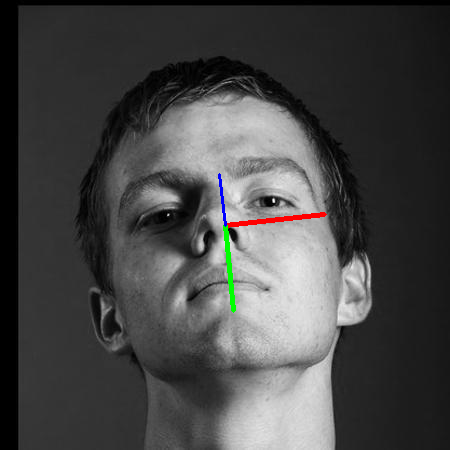

In [165]:
img = '/content/AFLW2000/image00854.jpg'
mat_file = sio.loadmat('/content/AFLW2000/image00854.mat')
frame = cv2.imread(img)
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(frame, pitch, yaw,roll))

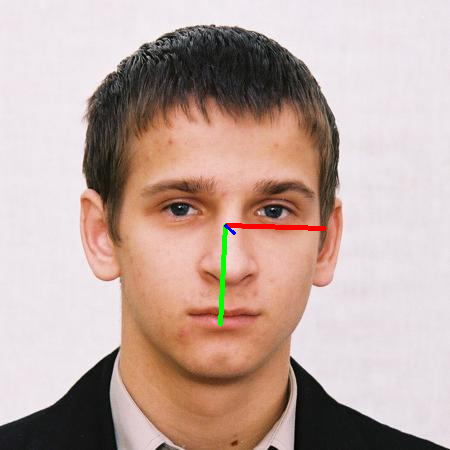

In [167]:
img = '/content/AFLW2000/image00053.jpg'
mat_file = sio.loadmat('/content/AFLW2000/image00053.mat')
frame = cv2.imread(img)
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(frame, pitch, yaw,roll))

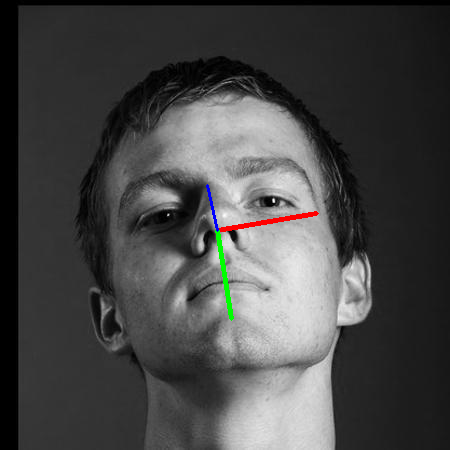

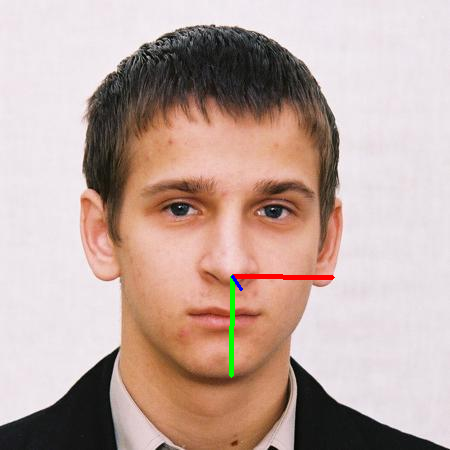

In [169]:
#SVR
img1 = '/content/AFLW2000/image00854.jpg'
img2 = '/content/AFLW2000/image00053.jpg'
frame = cv2.imread(img1)
nose, pitch, yaw, roll = pose_predict(frame, best_svm_model, yaw_svm_model, roll_svm_model)
cv2_imshow(draw_axis(frame, pitch, yaw,roll, nose[:,0]*frame.shape[1], nose[:,1]*frame.shape[0]))
frame = cv2.imread(img2)
nose, pitch, yaw, roll = pose_predict(frame, best_svm_model, yaw_svm_model, roll_svm_model)
cv2_imshow(draw_axis(frame, pitch, yaw,roll, nose[:,0]*frame.shape[1], nose[:,1]*frame.shape[0]))

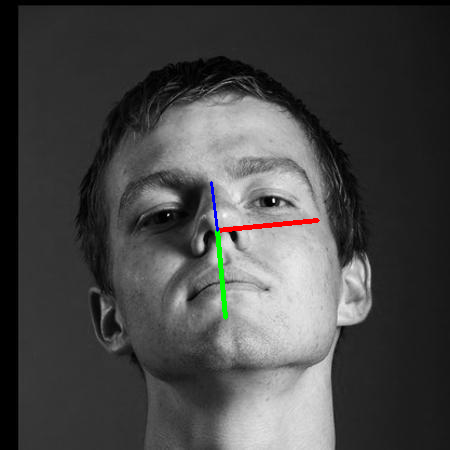

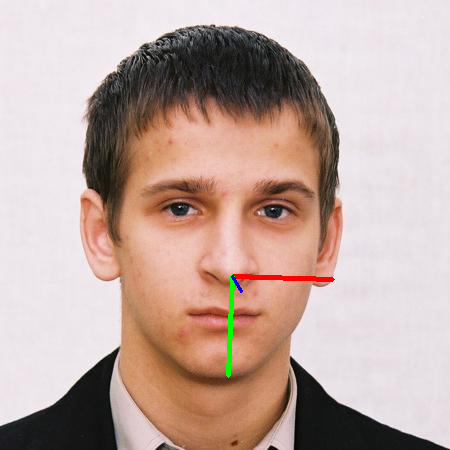

In [172]:
#Adaboost decision tree
img1 = '/content/AFLW2000/image00854.jpg'
img2 = '/content/AFLW2000/image00053.jpg'
frame = cv2.imread(img1)
nose, pitch, yaw, roll = pose_predict(frame, ab_pitch, ab_yaw, ab_roll)
cv2_imshow(draw_axis(frame, pitch, yaw,roll, nose[:,0]*frame.shape[1], nose[:,1]*frame.shape[0]))
frame = cv2.imread(img2)
nose, pitch, yaw, roll = pose_predict(frame, ab_pitch, ab_yaw, ab_roll)
cv2_imshow(draw_axis(frame, pitch, yaw,roll, nose[:,0]*frame.shape[1], nose[:,1]*frame.shape[0]))

Decided to go with SVR model at the end

In [180]:
video_file = "/content/F.R.I.E.N.D.S __ Chandler_ Because It's Sunday. It's God's Day. #shorts #friends #funny.mp4"
cap = cv2.VideoCapture(video_file)
output_video = '/content/drive/MyDrive/ML1/friends_svr.avi'
video_writer = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'MJPG'), int(cap.get(cv2.CAP_PROP_FPS)), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    # cv2_imshow(frame)
    try:
      nose, pitch, yaw, roll = pose_predict(frame, best_svm_model, yaw_svm_model, roll_svm_model)
      if pitch and yaw and roll:
        draw_axis(frame, pitch, yaw,roll, nose[:,0]*frame.shape[1], nose[:,1]*frame.shape[0])
      video_writer.write(frame)
    except Exception as e:
      print(e)

cap.release()
video_writer.release()
